In [1]:
!pip install numpy pandas seaborn matplotlib scikit-learn joblib
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# New Section

In [2]:
df = pd.read_csv("./dataset.csv")

In [3]:
print("Data Shape:",df.shape)

Data Shape: (20819, 10)


In [4]:
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [5]:
df.isnull()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
20814,False,False,False,False,False,False,False,False,False,False
20815,False,False,False,False,False,False,False,False,False,False
20816,False,False,False,False,False,False,False,False,False,False
20817,False,False,False,False,False,False,False,False,False,False


In [6]:
df.isnull().sum()

,0
Date,0
County,86
State,86
Vehicle Primary Use,0
Battery Electric Vehicles (BEVs),0
Plug-In Hybrid Electric Vehicles (PHEVs),0
Electric Vehicle (EV) Total,0
Non-Electric Vehicle Total,0
Total Vehicles,0
Percent Electric Vehicles,0


In [8]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[
    (df['Percent Electric Vehicles'] < lower_bound) |
    (df['Percent Electric Vehicles'] > upper_bound)
]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])


lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


In [9]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()


Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [10]:
# Cap the outliers
df['Percent Electric Vehicles'] = np.where(
    df['Percent Electric Vehicles'] > upper_bound, upper_bound,
    np.where(
        df['Percent Electric Vehicles'] < lower_bound, lower_bound,
        df['Percent Electric Vehicles']
    )
)

# Identify outliers
outliers = df[
    (df['Percent Electric Vehicles'] < lower_bound) |
    (df['Percent Electric Vehicles'] > upper_bound)
]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])


Number of outliers in 'Percent Electric Vehicles': 0


In [12]:
import pandas as pd

# List of columns to convert
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

# Convert each column to numeric, replace errors with NaN
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Show summary stats
print(df[cols_to_convert].describe())


       Battery Electric Vehicles (BEVs)  \
count                      20266.000000   
mean                          25.855176   
std                          102.004224   
min                            0.000000   
25%                            0.000000   
50%                            1.000000   
75%                            2.000000   
max                          999.000000   

       Plug-In Hybrid Electric Vehicles (PHEVs)  Electric Vehicle (EV) Total  \
count                              20468.000000                 20119.000000   
mean                                  21.790942                    31.623093   
std                                   92.309729                   115.742017   
min                                    0.000000                     0.000000   
25%                                    0.000000                     1.000000   
50%                                    1.000000                     1.000000   
75%                                    1.000000     

In [13]:
# Group by County and sum EV totals
ev_by_county = df.groupby('County')['Electric Vehicle (EV) Total'].sum()

# Top 3 counties with most EVs
top_counties = ev_by_county.sort_values(ascending=False).head(3)

# Bottom 3 counties with fewest EVs
bottom_counties = ev_by_county.sort_values().head(3)

# Print results
print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)


Top 3 Counties:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Union         1.0
Hood River    1.0
Name: Electric Vehicle (EV) Total, dtype: float64


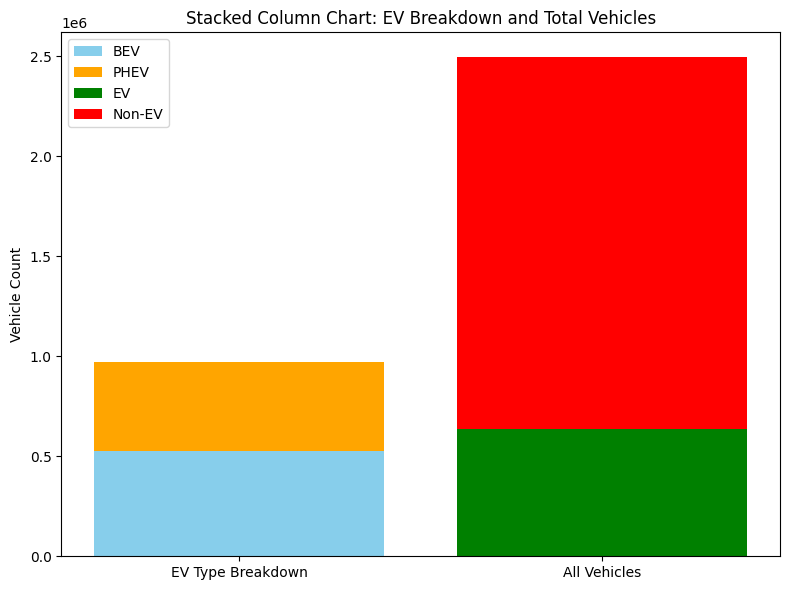

In [14]:
# Calculate totals for each vehicle type
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Create a blank chart to draw on
fig, ax = plt.subplots(figsize=(8, 6))

# Plot EV types (stacked bar)
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

# Plot all vehicles (stacked bar of EV and Non-EV)
ax.bar('All Vehicles', ev_total, label='EV', color='green')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='red')

# Add labels and legend
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [51]:
#  Extract parts of the date for time-based analysis
df['year'] = df['Date'].dt.year        # Get the year
df['month'] = df['Date'].dt.month      # Get the month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month  # Turn date into a number (for trend analysis)


In [52]:
#  Convert county names (text) into numbers for ML models


le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])  # Replace county names with numeric codes


In [53]:

#  Sort the data so we can calculate lag features properly
df = df.sort_values(['County', 'Date'])  # First by County, then by Date


In [54]:
# Track how many months have passed since the first record per county
df['months_since_start'] = df.groupby('County').cumcount()


In [55]:
# Create lag features (values from 1, 2, and 3 months ago)
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)


In [56]:
#  3-month rolling average of EV total (ignores current month, uses past 3)
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())


In [58]:
#  1-month percent change in EV total
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

#  3-month percent change in EV total
df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)


In [59]:
#  Replace infinite or missing values in percent change columns
import numpy as np

df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)


In [60]:
#  Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

#  Growth slope over a 6-month rolling window (linear trend)
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)


In [61]:
#  Drop rows with missing values (caused by lag, rolling, or slope calculations)
df = df.dropna().reset_index(drop=True)


In [62]:
#  Save preprocessed data to a CSV file
df.to_csv('preprocessed_ev_data.csv', index=False)

#  Preview the cleaned data
df.head()


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-10-31,Ada,ID,Passenger,0.0,2.0,2.0,326.0,328.0,0.61,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.0
1,2018-11-30,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.0
2,2018-12-31,Ada,ID,Passenger,0.0,2.0,2.0,324.0,326.0,0.61,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.0
3,2019-01-31,Ada,ID,Passenger,0.0,2.0,2.0,322.0,324.0,0.62,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.0
4,2019-02-28,Ada,ID,Passenger,0.0,2.0,2.0,320.0,322.0,0.62,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,20.0,2.0


In [63]:
#  Select the columns to be used as features (inputs for ML model)
features = [
    'months_since_start',         # How many months since data started
    'county_encoded',             # County as a numeric code
    'ev_total_lag1',              # EV total from 1 month ago
    'ev_total_lag2',              # EV total from 2 months ago
    'ev_total_lag3',              # EV total from 3 months ago
    'ev_total_roll_mean_3',       # 3-month rolling average of EV totals
    'ev_total_pct_change_1',      # 1-month % change in EV total
    'ev_total_pct_change_3',      # 3-month % change in EV total
    'ev_growth_slope'             # Growth trend (slope of cumulative EVs)
]

#  Set the column we want to predict
target = 'Electric Vehicle (EV) Total'

#  Split into input features (X) and target (y)
X = df[features]
y = df[target]

#  Preview the input features
X.head()


,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.0


In [64]:
X.shape

(11246, 9)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,shuffle=False, test_size=0.1)


In [66]:
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [67]:
y_pred=model.predict(X_test)

In [68]:
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
10121,60,235,2.0,1.0,2.0,1.666667,0.0,0.0,1.600000
10122,61,235,2.0,2.0,1.0,1.666667,-0.5,0.0,1.628571
10123,62,235,1.0,2.0,2.0,1.666667,0.0,-0.5,1.485714
10124,63,235,1.0,1.0,2.0,1.333333,1.0,0.0,1.514286
10125,64,235,2.0,1.0,1.0,1.333333,-0.5,0.0,1.371429


In [69]:
# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round predicted values for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optionally reset index if needed
comparison_df.reset_index(drop=True, inplace=True)

# Show the first 10 rows
print(comparison_df.head(10))

   Actual EV Count  Predicted EV Count
0              2.0                2.00
1              1.0                1.01
2              1.0                1.00
3              2.0                2.00
4              1.0                1.00
5              2.0                2.00
6              1.0                1.00
7              1.0                1.00
8              1.0                1.00
9              1.0                1.00


MAE: 0.01, RMSE: 0.05, R2 Score: 1.00


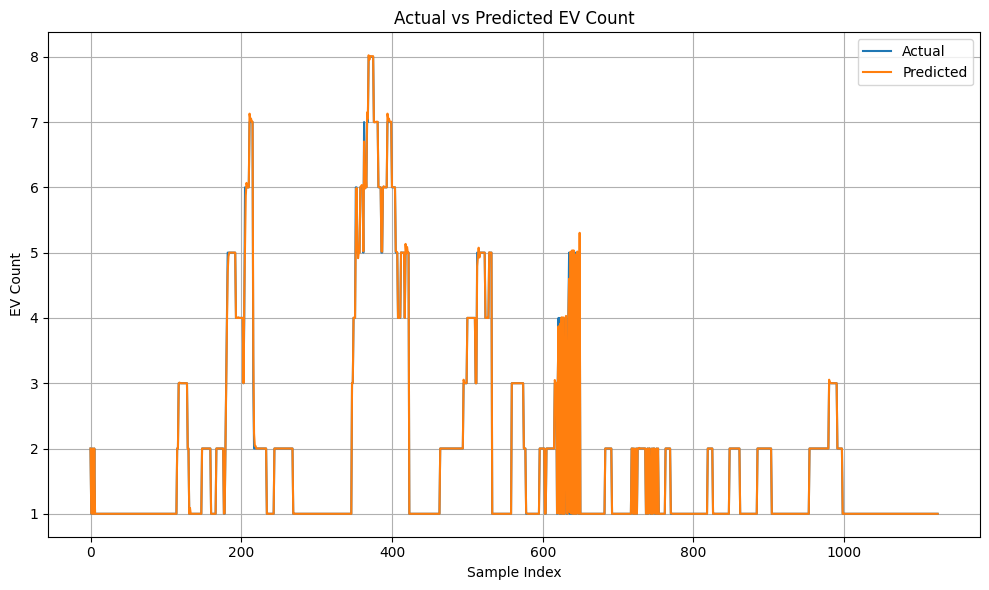

In [70]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

# Evaluate model performance
evaluate(y_test, y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


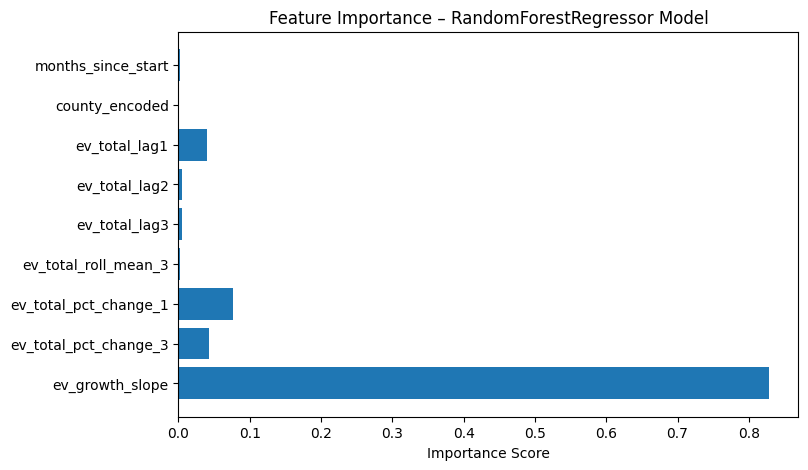

In [71]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.xlabel('Importance Score')

# Title updated to reflect the model type
plt.title('Feature Importance – RandomForestRegressor Model')

# Invert y-axis to show highest importance at the top
plt.gca().invert_yaxis()

plt.show()


In [72]:
# Define features to extract for counties
featuresX = ['County', 'county_encoded']

# Select these features from the dataframe
countyX = df[featuresX]

# Print unique counties, dropping any missing values first
print("List of unique counties:")
print(df['County'].dropna().unique())

# Print the total number of unique counties
print("Total unique counties:", df['County'].nunique())

List of unique counties:
['Ada' 'Adams' 'Alameda' 'Albemarle' 'Alexandria' 'Allegheny' 'Allen'
 'Anchorage' 'Anne Arundel' 'Arapahoe' 'Arlington' 'Atlantic' 'Autauga'
 'Baltimore' 'Bartow' 'Beaufort' 'Bell' 'Bergen' 'Berkeley' 'Berkshire'
 'Bexar' 'Boone' 'Boulder' 'Bradley' 'Brevard' 'Broward' 'Bucks'
 'Burlington' 'Caddo' 'Calvert' 'Camden' 'Canyon' 'Carroll' 'Carson City'
 'Cascade' 'Champaign' 'Charles' 'Charleston' 'Chesapeake' 'Clackamas'
 'Clay' 'Clinton' 'Cochise' 'Collier' 'Collin' 'Columbia' 'Contra Costa'
 'Cook' 'Coryell' 'Cumberland' 'Currituck' 'Dakota' 'Dale' 'Dallas'
 'Danville' 'DeKalb' 'Denton' 'Denver' 'Deschutes' 'District of Columbia'
 'Dorchester' 'Douglas' 'DuPage' 'Duval' 'Eagle' 'Eau Claire' 'El Dorado'
 'El Paso' 'Escambia' 'Essex' 'Fairbanks North Star' 'Fairfax' 'Flathead'
 'Fort Bend' 'Franklin' 'Frederick' 'Fresno' 'Fulton' 'Galveston'
 'Garfield' 'Geary' 'Goochland' 'Greene' 'Guadalupe' 'Gwinnett' 'Hamilton'
 'Hampshire' 'Hardin' 'Harford' 'Harnett' 'Harr

In [73]:
# Set your target county name
county = "Kings"

# Encode the county name using LabelEncoder (le)
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}.")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")

if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()
# Prepare EV history for the county
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
slope_history = []
months_since_start = county_df['months_since_start'].max()

historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    # Compute next month date
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    # Get lagged values from historical_ev
    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]

    # Calculate rolling mean and percent changes
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

    # Compute slope using last 6 cumulative values
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    # Construct new forecast row
    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    # Predict next EV count using your model
    next_ev_count = model.predict(pd.DataFrame([new_row]))[0]

    # Append the predicted EV count to historical lists for next iteration
    historical_ev.append(next_ev_count)
    cumulative_ev.append(cumulative_ev[-1] + next_ev_count)

    # Add the predicted EV count and date info to the new row
    new_row.update({
        'year': y,
        'month': m,
        'numeric_date': numeric_date,
        'Electric Vehicle (EV) Total': next_ev_count,
        'Source': 'Forecast',
        'Date': next_date
    })

    # Save the new row
    future_rows.append(new_row)

    # Update latest_row for next iteration
    latest_row = pd.Series(new_row)

# Convert forecasted rows to DataFrame
forecast_df = pd.DataFrame(future_rows)

historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)


County 'Kings' encoded as 113.


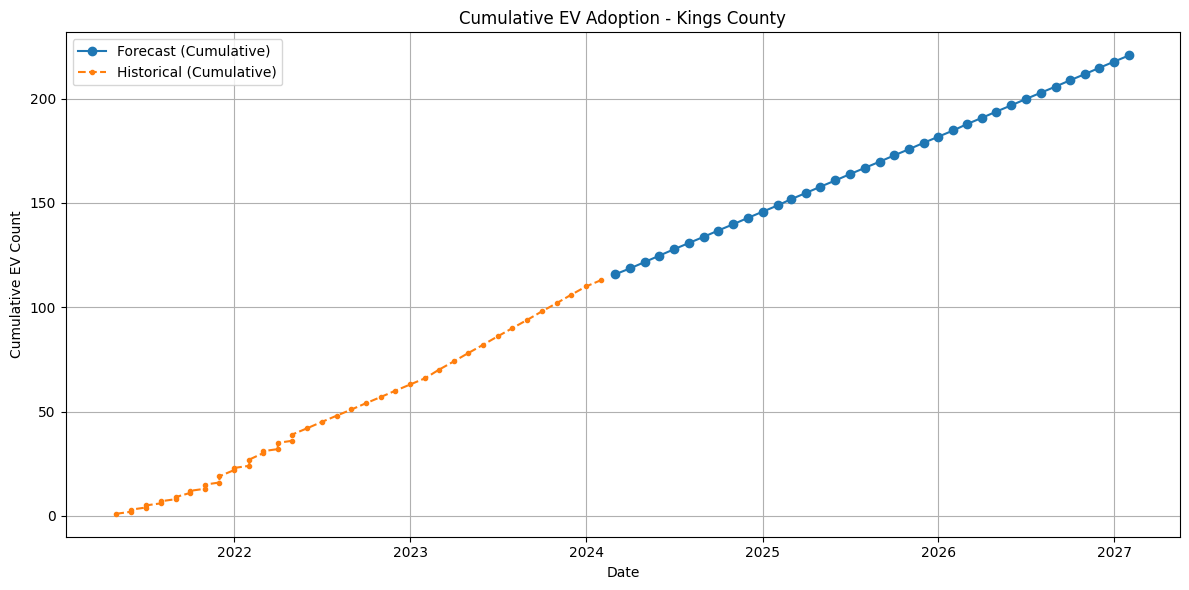

In [74]:
# Sort by date to ensure proper cumulative behavior
combined = combined.sort_values("Date")

# Calculate cumulative EV count
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# Plot cumulative EV adoption
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.',
             linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [75]:
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")


Model saved to 'forecasting_ev_model.pkl'


In [76]:

# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")


Model loaded successfully.


In [77]:

# Make predictions
# Test prediction on new or existing sample
sample = X_test.iloc[[0]]  # use one row as test (note double brackets to keep 2D shape)
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f"\n🔍 Testing saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")



🔍 Testing saved model on 1 sample:
Actual EVs: 2.00, Predicted EVs: 2.00
